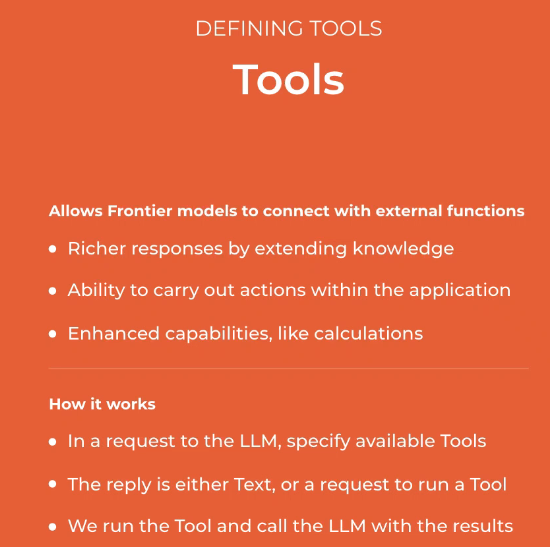
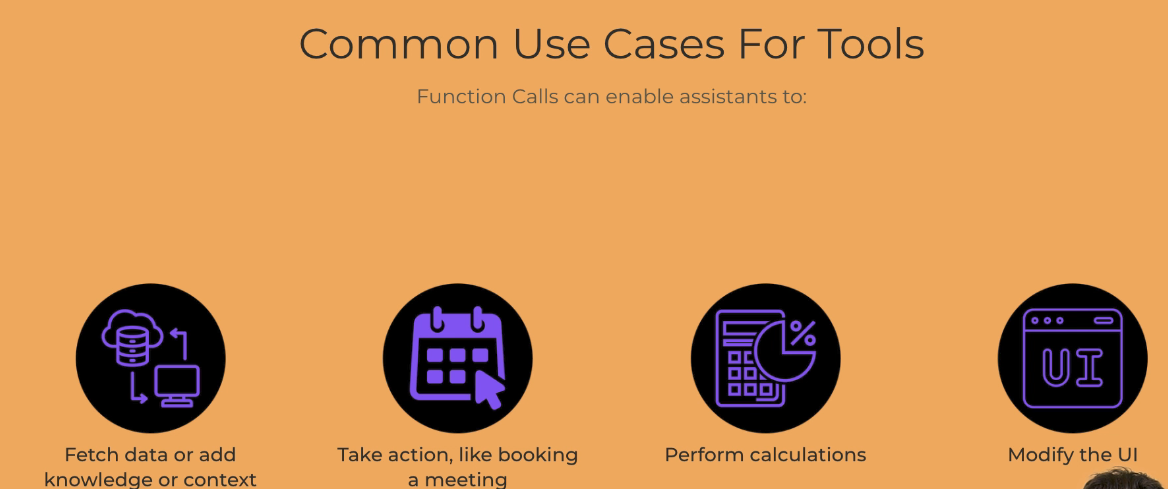

# Project - Airline AI Assistant

We'll now bring together what we've learned to make an AI Customer Support assistant for an Airline

In [1]:
# imports

import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# Initialization

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

# As an alternative, if you'd like to use Ollama instead of OpenAI
# Check that Ollama is running for you locally (see week1/day2 exercise) then uncomment these next 2 lines
# MODEL = "llama3.2"
# openai = OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')


OpenAI API Key exists and begins sk-proj-


In [7]:
system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [8]:
# This function looks rather simpler than the one from my video, because we're taking advantage of the latest Gradio updates

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages)
    return response.choices[0].message.content

gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


## Tools

Tools are an incredibly powerful feature provided by the frontier LLMs.

With tools, you can write a function, and have the LLM call that function as part of its response.

Sounds almost spooky.. we're giving it the power to run code on our machine?

Well, kinda.

In [9]:
# Let's start by making a useful function

ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [10]:
get_ticket_price("Berlin")

Tool get_ticket_price called for Berlin


'$499'

Tool dictionary:
- The description is VERY important it has to be done in proper english. This will be added to the LLM system promt to know when to use the function. It's always helpful to give an example in the description (like one-shot)

In [11]:
# There's a particular dictionary structure that's required to describe our function:

price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [12]:
# And this is included in a list of tools:

tools = [{"type": "function", "function": price_function}]

## Getting OpenAI to use our Tool

There's some fiddly stuff to allow OpenAI "to call our tool"

What we actually do is give the LLM the opportunity to inform us that it wants us to run the tool.
But we are the one calling the function tool eventually, not the LLM!!

Here's how the new chat function looks:

In [26]:
def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)  # add our tool

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        print(message)
        response, city = handle_tool_call(message)
        messages.append(message)  # assitant message asking us to call the tool
        messages.append(response) # the result of the tool.
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content

In [27]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)  # WE call the function here!!
    
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),  # content is input and output from the function_tool
        "tool_call_id": tool_call.id
    }
    return response, city

In [28]:
gr.ChatInterface(fn=chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_hya6y8kBSBzzkCAA6VMYm1b9', function=Function(arguments='{"destination_city":"Berlin"}', name='get_ticket_price'), type='function')])
Tool get_ticket_price called for Berlin
ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_qx2lBWWuIJAbB5bv9CXNJGZO', function=Function(arguments='{"destination_city":"Tokyo"}', name='get_ticket_price'), type='function')])
Tool get_ticket_price called for Tokyo
ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_HJHDvoe6pLX9Clao8NBn8m1m', function=Function(arguments='{"destination_city":"New York"}', name='get_ticket_price'), type='function')])
Tool get_ticket_price called for New York
